(https://stackabuse.com/python-for-nlp-creating-a-rule-based-chatbot/)

In [51]:
allowed_states = """
entry: a,b,c

a: entry, a1, a2
 a1: entry
 a2: entry
b: entry
c: entry

"""

In [85]:
allowed_states = """
entry: plot, add_legend, add_legend_top_right, add_legend_top_left

plot: entry
add_legend: add_legend_top_right, add_legend_top_left, entry
add_legend_top_right: entry
add_legend_top_left: end

"""

In [86]:
state_to_command = {
    'entry': [],
    'plot': ["plt.plot(x)"],
    'add_legend': [],
    'add_legend_top_right': ["plt.legend(['test'], loc='upper right')"],
    'add_legend_top_left': ["plt.legend(['test'], loc='upper left')"],
}

In [87]:
state_user_message = {
    'add_legend': "Would you like to place the legend to the left or the right?"
}

In [88]:
def states_string_to_data_structure(input_string):
    temp1 = [ x.strip() for x in input_string.split('\n') if x.strip() != "" ]
    temp2 = [ x.split(':') for x in temp1 ]
    def f(x):
        result = [ y.strip() for y in x.split(',') if y.strip() != "" ]
        return result
    states = { x[0].strip() : f(x[1]) for x in temp2 }
    return states

In [89]:
states = states_string_to_data_structure(allowed_states)

please select from ['plot', 'add_legend', 'add_legend_top_right', 'add_legend_top_left']


 add_legend_top_right


add_legend_top_right


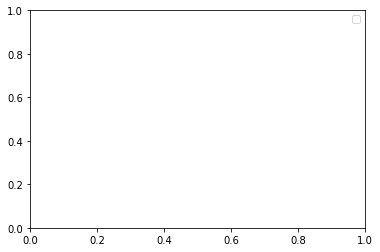

entry


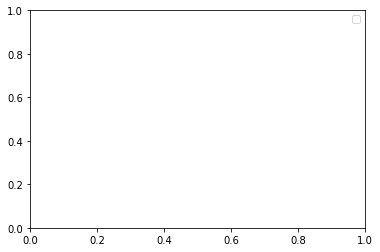

please select from ['plot', 'add_legend', 'add_legend_top_right', 'add_legend_top_left']


 plot


plot


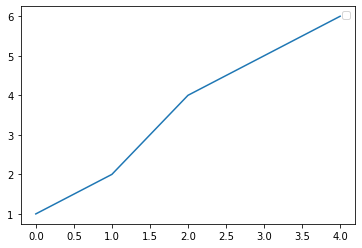

entry


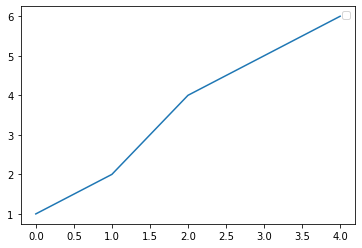

please select from ['plot', 'add_legend', 'add_legend_top_right', 'add_legend_top_left']


 add_legend_top_right


add_legend_top_right


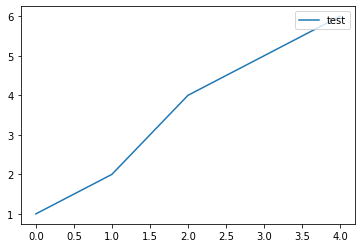

entry


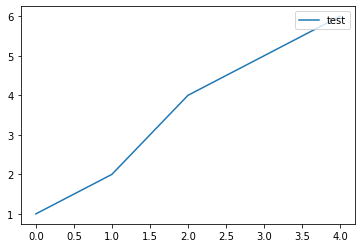

please select from ['plot', 'add_legend', 'add_legend_top_right', 'add_legend_top_left']


In [ ]:
flag=True
curr_state = 'entry'
all_states = ['entry']
all_commands = []

while(flag):
    possible_next_steps = states[curr_state]
    if len(possible_next_steps) > 1:
        print("please select from", possible_next_steps)
        my_in = input()
    else:
        my_in = possible_next_steps[0]
    
    if my_in.lower() == 'end':
        flag = False
    elif my_in not in possible_next_steps:
        print("Sry, couldn't understand you!")
        continue
    else: # so my_in is now in possible_next_steps
        print(state_user_message.get(my_in,my_in))
        all_states.append(my_in)
        all_commands.extend(state_to_command.get(my_in,[]))
        #
        [ eval(bla, globals(), locals()) for bla in all_commands ]
        plt.show()
        #
        curr_state = my_in
print('bye')

In [80]:
all_states

['entry', 'plot', 'entry', 'add_legend', 'add_legend_top_right']

In [81]:
all_commands

['plt.plot(x)', "plt.legend(['test'], loc='upper right')"]

In [61]:
%matplotlib inline
from matplotlib import pyplot as plt

In [91]:
x= [1,2,4,5,6]

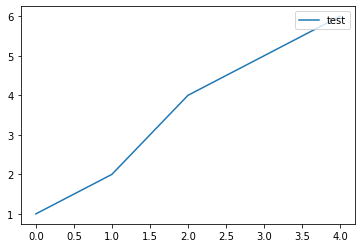

In [95]:
plt.plot(x)
plt.legend(['test'], loc='upper right')